In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import seaborn as sns

# Functions

In [2]:
def check_dir(dir: str):
    """
    Creates a given path directory if it does not exist.

    Args:
        dir (str): Path to the directory to be created.
    """
    if os.path.exists(dir) and os.path.isdir(dir):
        pass
    else:
        os.makedirs(dir)

def compute_wcss(data, labels, n_clusters):
    """
    Compute the Within-Cluster Sum of Squares (WCSS) for clustering results.
    
    Parameters
    ----------
    data : numpy.ndarray
        The similarity/distance matrix used for clustering
    labels : numpy.ndarray
        Cluster labels for each data point
    n_clusters : int
        Number of clusters
        
    Returns
    -------
    float
        The computed WCSS value
    """
    wcss = 0
    for i in range(n_clusters):
        cluster_data = data[labels == i]
        cluster_center = cluster_data.mean(axis=0)
        wcss += np.sum((cluster_data - cluster_center) ** 2)
    return wcss

def convert_to_set(x):
    """
    Convert string representation of sets to actual Python sets.
    
    Parameters
    ----------
    x : str or set
        Input to convert to set
        
    Returns
    -------
    set
        Converted set or original input if already a set
    """
    if isinstance(x, str):
        return set(eval(x))
    return x

def jaccard_similarity(genes_i, genes_j):
    """
    Calculate Jaccard similarity between two sets.
    
    Parameters
    ----------
    genes_i : set
        First set of genes
    genes_j : set
        Second set of genes
        
    Returns
    -------
    float
        Jaccard similarity score between 0 and 1
    """
    return len(genes_i & genes_j) / len(genes_i | genes_j)

def compute_row(i, combined_stat_sig, n):
    """
    Compute a row of the Jaccard similarity matrix.
    
    Parameters
    ----------
    i : int
        Row index
    combined_stat_sig : pandas.DataFrame
        DataFrame containing gene intersections
    n : int
        Total number of terms
        
    Returns
    -------
    numpy.ndarray
        Row of Jaccard similarities
    """
    genes_i = combined_stat_sig.iloc[i]['intersections']
    row = np.zeros(n)
    for j in range(i+1, n):
        genes_j = combined_stat_sig.iloc[j]['intersections']
        row[j] = jaccard_similarity(genes_i, genes_j)
    return row

def perform_clustering_analysis(combined_stat_sig, driver_stats, random_state=42, log_ratio_threshold=-10):
    """
    Perform hierarchical clustering analysis on gene sets using Jaccard similarity
    and identify clusters with extreme depletion patterns.
    
    [Previous docstring content remains the same...]
    
    Parameters
    ----------
    combined_stat_sig : pandas.DataFrame
        DataFrame containing gene sets
    driver_stats : pandas.DataFrame
        DataFrame containing driver gene information
    random_state : int, optional (default=42)
        Random seed for reproducibility
    log_ratio_threshold : float, optional (default=-10)
        Threshold for identifying extreme depletion in log-ratio values
        
    Returns
    -------
    tuple
        - jaccard_matrix : numpy.ndarray
            Matrix of pairwise Jaccard similarities
        - labels : numpy.ndarray
            Cluster assignments for each term
        - cluster_df : pandas.DataFrame
            Summary of clusters and their contents
        - heatmap_pivot : pandas.DataFrame
            Processed data for heatmap visualization
        - extreme_clusters : pandas.DataFrame
            Clusters showing extreme depletion patterns
        - cluster_terms : pandas.DataFrame
            Terms associated with extreme clusters
    """
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Reset index to ensure consistent ordering
    combined_stat_sig = combined_stat_sig.reset_index(drop=True)
    
    # Convert intersections to sets
    combined_stat_sig['intersections'] = combined_stat_sig['intersections'].apply(convert_to_set)
    
    # Sort terms by the number of genes in intersections
    combined_stat_sig['num_genes'] = combined_stat_sig['intersections'].apply(len)
    combined_stat_sig = combined_stat_sig.sort_values('num_genes', ascending=False).reset_index(drop=True)
    
    # Initialize the Jaccard similarity matrix
    n = len(combined_stat_sig)
    jaccard_matrix = np.zeros((n, n))
    
    # Calculate Jaccard similarities in parallel
    # Note: This is deterministic because Jaccard similarity is deterministic
    # and the input order is fixed
    jaccard_matrix = np.array(Parallel(n_jobs=-1)(
        delayed(compute_row)(i, combined_stat_sig, n) for i in range(n)))
    
    # Make the matrix symmetric
    jaccard_matrix = jaccard_matrix + jaccard_matrix.T
    
    # Elbow method analysis
    max_clusters = 100
    wcss_values = []
    
    for k in range(2, max_clusters + 1):
        clustering = AgglomerativeClustering(
            n_clusters=k, 
            metric='precomputed', 
            linkage='complete'
        )
        labels = clustering.fit_predict(1 - jaccard_matrix)
        wcss = compute_wcss(jaccard_matrix, labels, k)
        wcss_values.append(wcss)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), wcss_values, marker='o')
    plt.title('Elbow Method For Optimal Number of Clusters (Complete Linkage)')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.show()
    
    # Perform final clustering
    n_clusters = 93  # Set based on elbow analysis
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='precomputed',
        linkage='complete'
    )
    labels = clustering.fit_predict(1 - jaccard_matrix)
    
    # Add cluster labels to dataframe
    combined_stat_sig['Cluster'] = labels
    
    # Group terms by clusters
    clustered_terms = []
    for cluster_label in sorted(np.unique(labels)):  # Sort for reproducibility
        cluster_terms = combined_stat_sig[combined_stat_sig['Cluster'] == cluster_label]
        term_names = sorted(cluster_terms['Name'].tolist())  # Sort for reproducibility
        combined_genes = set().union(*cluster_terms['intersections'])
        clustered_terms.append({
            'Cluster': cluster_label,
            'Terms': term_names,
            'Combined Genes': combined_genes
        })
    
    # Create cluster DataFrame
    cluster_df = pd.DataFrame(clustered_terms)
    
    # Calculate driver statistics
    total_drivers = driver_stats['group'].value_counts().to_dict()
    heatmap_data = []
    
    # Calculate category counts and log ratios
    for idx, row in cluster_df.iterrows():
        cluster_label = row['Cluster']
        combined_genes = row['Combined Genes']
        num_combined_genes = len(combined_genes)
        
        category_counts = {category: 0 for category in sorted(total_drivers.keys())}  # Sort for reproducibility
        for gene in sorted(combined_genes):  # Sort for reproducibility
            if gene in driver_stats.index:
                category = driver_stats.loc[gene, 'group']
                if category in category_counts:
                    category_counts[category] += 1
        
        for category in sorted(category_counts.keys()):  # Sort for reproducibility
            observed = category_counts[category]
            expected = total_drivers[category] * (num_combined_genes / len(driver_stats))
            log_ratio = np.log((observed + 1e-6) / (expected + 1e-6))
            heatmap_data.append({
                'Cluster': cluster_label,
                'Category': category,
                'LogRatio': log_ratio
            })
    
    # Create and plot heatmap
    heatmap_df = pd.DataFrame(heatmap_data)
    heatmap_pivot = heatmap_df.pivot(index="Cluster", columns="Category", values="LogRatio")
    heatmap_pivot = heatmap_pivot[['non_sign', 'neg', 'more_neg', 'neutral', 'more_pos', 'pos']]
    
    # Identify clusters with extreme depletion
    extreme_clusters = heatmap_df[heatmap_df['LogRatio'] <= log_ratio_threshold].sort_values('LogRatio')
    
    # Get unique cluster numbers showing extreme depletion
    extreme_cluster_numbers = sorted(extreme_clusters['Cluster'].unique())
    
    # Extract terms for these clusters
    cluster_terms = cluster_df[cluster_df['Cluster'].isin(extreme_cluster_numbers)][['Cluster', 'Terms']]
    
    # Create visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        heatmap_pivot,
        annot=False,
        cmap="RdYlGn",
        center=0,
        cbar_kws={'label': 'Log(Observed/Expected) Ratio'}
    )
    plt.title(f"Heatmap of Log(Observed/Expected) Ratio for Driver Categories per Cluster (n_clusters={n_clusters})")
    plt.show()
    
    # Print analysis results
    print("\nClusters with extreme depletion patterns:")
    print("----------------------------------------")
    print(f"Found {len(extreme_cluster_numbers)} clusters with log-ratio values ≤ {log_ratio_threshold}")
    print("\nDetailed analysis of extreme clusters:")
    print(extreme_clusters[['Cluster', 'Category', 'LogRatio']].to_string())
    
    print("\nTerms in extreme clusters:")
    print("-------------------------")
    for _, row in cluster_terms.iterrows():
        print(f"\nCluster {row['Cluster']}:")
        for term in row['Terms']:
            print(f"  - {term}")
    
    return jaccard_matrix, labels, cluster_df, heatmap_pivot, extreme_clusters, cluster_terms

# Directories

In [3]:
datadir = "data/"
check_dir(datadir)

# Load Datasets

In [4]:
filt_drivers = pd.read_csv(datadir + "filtered_drivers.csv")

In [5]:
driver_stats = filt_drivers[['driver', 'n_neighbours', 'pos_dints', 'neg_dints', 'pos_pct', 'neg_pct', 'group']].copy()
driver_stats = driver_stats.set_index('driver')

In [6]:
final_results_df = pd.read_csv(datadir + 'enrichment_results.csv')

In [7]:
combined_stat = pd.read_csv(datadir + "combined_statistical_results.csv")
combined_stat_sig = combined_stat[combined_stat['adjusted.p.value'] < 0.05].copy() 
print(len(combined_stat_sig))
significant_terms = combined_stat_sig['Name'].tolist()
combined_stat_sig = final_results_df.merge(combined_stat_sig, on=['Name', 'Source'], how='inner')

2364


# Agglomerative Clustering 

To further investigate the functional organization of cancer driver genes, agglomerative clustering was employed to group enriched terms based on the similarity of their gene sets. The similarity was quantified using the Jaccard index, which measures the overlap between gene sets associated with each term. The objective was to form clusters of terms that share a high degree of gene overlap, thereby representing related biological processes or functions. This approach enables the identification of functionally
cohesive clusters where shared biological processes might be linked to similar gene functions in cancer progression.

Complete linkage was selected as the clustering method, as it tends to create compact clusters by maximising the distance between terms in different clusters. This method ensures that terms within each cluster are highly similar to each other, making the resulting clusters more biologically meaningful.

By applying the elbow method, 93 clusters were identified as the optimal number, balancing the trade-off between cluster compactness and the number of clusters, ensuring interpretable biological insights.

Once the clustering was performed, we analysed the composition of each cluster by calculating the log-transformed observed/expected ratio of drivers across the six predefined driver categories. This analysis was crucial for identifying clusters where certain driver categories were significantly over- or underrepresented, highlighting areas where specific drivers are either enriched or depleted.

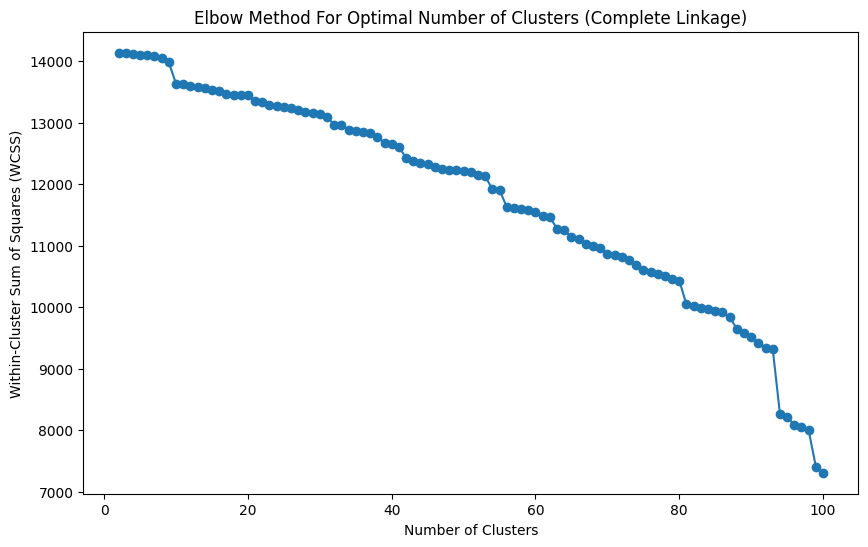

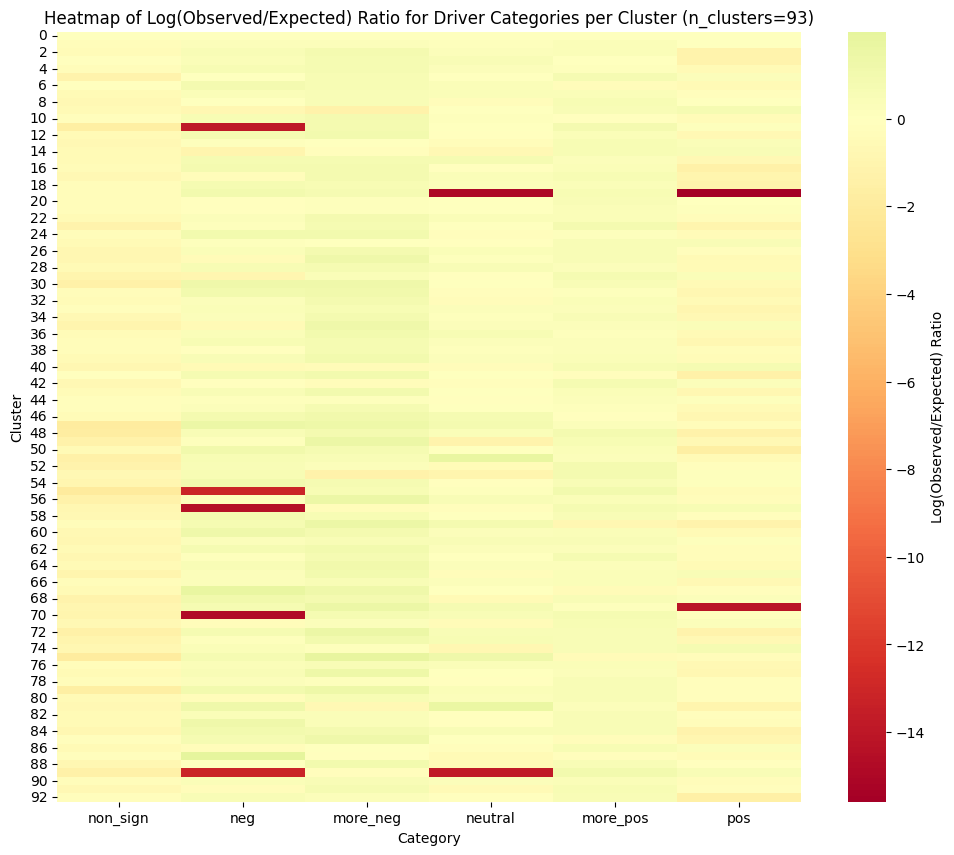


Clusters with extreme depletion patterns:
----------------------------------------
Found 7 clusters with log-ratio values ≤ -10

Detailed analysis of extreme clusters:
     Cluster Category   LogRatio
119       19      pos -15.586258
117       19  neutral -14.990410
422       70      neg -14.802898
344       57      neg -14.551583
419       69      pos -14.286976
68        11      neg -13.874185
537       89  neutral -13.816291
536       89      neg -13.241663
332       55      neg -13.116500

Terms in extreme clusters:
-------------------------

Cluster 11:
  - Mammary gland development pathway Embryonic development Stage 1 of 4 
  - Mammary gland development pathway Pregnancy and lactation Stage 3 of 4 
  - nitric-oxide synthase regulator activity
  - positive regulation of G1/S transition of mitotic cell cycle
  - positive regulation of cell cycle G1/S phase transition

Cluster 19:
  - cell differentiation involved in kidney development
  - epithelial cell differentiation involved 

In [11]:
jaccard_matrix, labels, cluster_df, heatmap_pivot, extreme_clusters, cluster_terms = perform_clustering_analysis(
    combined_stat_sig,
    driver_stats,
    random_state=42,
    log_ratio_threshold=-10
)


A heatmap was generated to visualise the Log(Observed/Expected) ratios for each driver category across the clusters, revealing patterns of enrichment or depletion. These patterns offer insights into how driver-neighbour interactions may differ across biological processes.

Clusters with extreme log-ratio values, particularly those showing strong depletion, are of special interest because they indicate substantial deviations from the expected distribution of drivers. For instance, Cluster 19 exhibited a pronounced depletion in the pos and neutral driver categories, while Cluster 57 displayed a notable under-representation in the neg category. This strong depletion suggests that drivers from these categories are less likely to participate in the biological processes represented by these clusters, providing insight into potential mechanisms of tumour suppression or activation.

In [12]:
# Access extreme clusters analysis
print("\nSummary of extreme clusters:")
print(extreme_clusters[['Cluster', 'Category', 'LogRatio']].sort_values('LogRatio'))


Summary of extreme clusters:
     Cluster Category   LogRatio
119       19      pos -15.586258
117       19  neutral -14.990410
422       70      neg -14.802898
344       57      neg -14.551583
419       69      pos -14.286976
68        11      neg -13.874185
537       89  neutral -13.816291
536       89      neg -13.241663
332       55      neg -13.116500


The following table summarises the enriched terms for selected clusters that exhibited extreme negative log-ratio values. These clusters highlight biological processes where certain driver categories, such as neg, pos, and neutral, are significantly depleted. The under-representation of these driver categories in specific clusters indicates that the corresponding biological processes may operate independently of these driver types, or that driver interactions in these processes are minimal. Such information is valuable for identifying pathways that may act as barriers to tumour progression or pathways that maintain cellular equilibrium, making them potential targets for therapeutic intervention.

In [13]:
# Access terms for specific clusters
selected_clusters = extreme_clusters['Cluster']
selected_terms = cluster_terms[cluster_terms['Cluster'].isin(selected_clusters)]
print("\nTerms in selected extreme clusters:")
print(selected_terms)


Terms in selected extreme clusters:
    Cluster                                              Terms
11       11  [Mammary gland development pathway Embryonic d...
19       19  [cell differentiation involved in kidney devel...
55       55  [actomyosin contractile ring assembly, actomyo...
57       57  [condensed nuclear chromosome, condensin compl...
69       69  [estrous cycle, regulation of hormone metaboli...
70       70  [Angiogenesis, CAMKK2 pathway, Clear cell rena...
89       89  [facultative heterochromatin formation, regula...


In [16]:
# Save selected terms to a csv file in datadir
selected_terms.to_csv(datadir + 'selected_terms.csv', index=False)